In [1]:
# Import relevant modules

# Import modules for vector calculations
import numpy as np
import scipy as sp
import pandas as pd
import scipy.linalg as la
import scipy.optimize as opt

# Import modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
%matplotlib inline

# Import modules for file handling 
import os
import io
import sys
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from tifffile import imread, imsave
from skimage import io, measure
import time

# Import modules for Deep Learning
import torch as torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchsummary import summary
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

# Import custom modules
from U_netResnet import *
from BinomDataset import BinomDataset
from Inference import sample_image
torch.set_float32_matmul_precision('medium')

In [2]:
!nvidia-smi

Fri Jun  7 13:34:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.83                 Driver Version: 546.83       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P8               5W / 120W |   1191MiB / 12282MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Using the GPU for computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
Data = np.concatenate((imread(r'trainingDataGT.tif'), imread(r'testDataGT.tif')))

(2048, 512, 512)


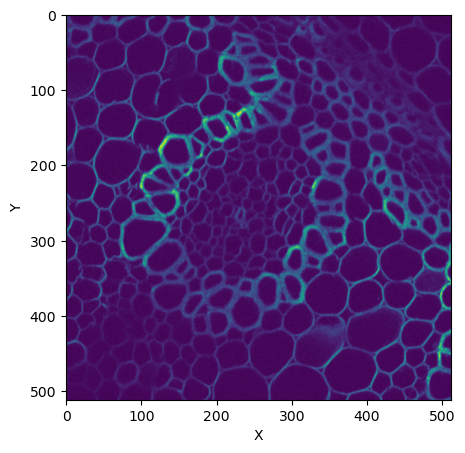

In [5]:
# Review the Dataset
plt.figure(figsize=(5,5))
plt.imshow(Data[0], cmap='viridis')
print(Data.shape)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [6]:
def psnrToString(inp):
    if inp < 0:
        return "m"+str(-inp)
    else:
        return str(inp)
    
# We set the pseudo PSNR range used for splitting the images into input and target
minpsnr = -40
maxpsnr = -5

name = psnrToString(minpsnr) + "to" + psnrToString(maxpsnr) + "-256x256"
CHECKPOINT_PATH = "./models/" 

In [7]:
maxepochs = 20 # Train for longeer if needed

# Create the pytorch dataset
Dataset = BinomDataset(Data[:round(Data.shape[0]*0.8)], 256, minpsnr, maxpsnr, virtSize= 500*32)
Dataset_val = BinomDataset(Data[round(Data.shape[0]*0.8):], 256, minpsnr, maxpsnr)

# Create the Dataloaders for the training and validation sets
Train_Loader = DataLoader(Dataset, batch_size = 32, shuffle = True, drop_last = True, pin_memory=False)
Validation_Loader = DataLoader(Dataset_val, batch_size = 32, shuffle = False, drop_last = True, pin_memory=False)

img = next(iter(Train_Loader))

print("Image Shape: ",img.shape)

# Define the callbacks for the model training and validation.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min', verbose=True)


# Create the U-net model
in_channels = 1
channels_per_layer = [8, 16, 32, 64, 128]
attention = [False, False, False, False, False, False]
num_heads = 8
num_layers = 6

Model = Unet(in_channels, channels_per_layer, num_layers, attention, num_heads, groups = 1, dropout_rate= 0.2, up_mode = "Transpose", Merger = "add", Experimental = False).to(device)
summary(Model, (1, 256, 256))

Image Shape:  torch.Size([32, 2, 256, 256])
[6, 8, 16, 32, 64, 128]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]              56
            Conv2d-2          [-1, 8, 256, 256]              56
            Conv2d-3          [-1, 8, 256, 256]             440
            Conv2d-4          [-1, 8, 256, 256]           1,208
   Inception_Block-5         [-1, 24, 256, 256]               0
            Conv2d-6          [-1, 8, 256, 256]             200
              GELU-7          [-1, 8, 256, 256]               0
         GroupNorm-8          [-1, 8, 256, 256]              16
         Dropout2d-9          [-1, 8, 256, 256]               0
        MaxPool2d-10          [-1, 8, 128, 128]               0
        DownBlock-11  [[-1, 8, 128, 128], [-1, 8, 256, 256]]               0
           Conv2d-12         [-1, 16, 128, 128]             144
           Conv2d-13  

In [8]:
iter(Train_Loader)

In [15]:
Prediction = Predictions[0].cpu().numpy()
Prediction.shape

(32, 2, 256, 256)

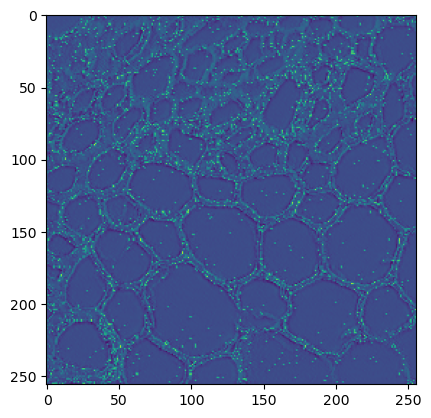

In [17]:
plt.imshow(Prediction[0,0], cmap='viridis')
plt.show()

In [14]:
for iter in Train_Loader:
    print(iter.shape)
    break

torch.Size([32, 2, 256, 256])


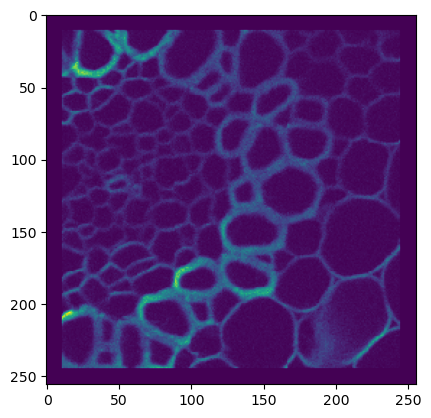

In [12]:
plt.imshow(img[0,0], cmap='viridis')
plt.show()

In [9]:
for iter in Validation_Loader:
    print(iter.shape)
    break

torch.Size([32, 2, 256, 256])


In [10]:
for iter in Train_Loader:
    print(iter.shape)
    break

torch.Size([32, 2, 256, 256])


In [13]:
# Define the Pytorch Trainer
Trainer = pl.Trainer(accelerator = "gpu", max_epochs=maxepochs, callbacks=[early_stopping_callback, lr_monitor, checkpoint_callback], gradient_clip_val=0.5, devices=[0])
Trainer.fit(Model, Train_Loader, Validation_Loader)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH,name) + ".ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | ModuleList | 460 K 
1 | bottleneck | ModuleList | 639 K 
2 | decoder    | ModuleList | 55.5 K
3 | final_conv | Conv2d     | 7     
------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.624     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 10.649
Epoch 0, global step 500: 'val_loss' reached 10.64915 (best 10.64915), saving model to "c:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\lightning_logs\\version_9\\checkpoints\\epoch=0-step=500.ckpt" as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 10.622
Epoch 2, global step 1500: 'val_loss' reached 10.62223 (best 10.62223), saving model to "c:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\lightning_logs\\version_9\\checkpoints\\epoch=2-step=1500.ckpt" as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 10.608
Epoch 3, global step 2000: 'val_loss' reached 10.60762 (best 10.60762), saving model to "c:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\lightning_logs\\version_9\\checkpoints\\epoch=3-step=2000.ckpt" as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 10.563
Epoch 4, global step 2500: 'val_loss' reached 10.56346 (best 10.56346), saving model to "c:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\lightning_logs\\version_9\\checkpoints\\epoch=4-step=2500.ckpt" as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 3000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 3500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 4000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 4500: 'val_loss' was not in top 1


In [12]:
Trainer.test(Model, Validation_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    11.010852813720703     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 11.010852813720703}]

In [14]:
Trainer.test(Model, Validation_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     10.63244342803955     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 10.63244342803955}]

In [14]:
for index in range(1,num_layers-1):
    print(channels_per_layer[-index], channels_per_layer[-index-1])

128 64
64 32
32 16
16 8
